## Notebook Setup

Let's start by downloading the dataset (if not already done) and seting up the notebook:

In [1]:
!wget https://github.com/lompabo/aiiti-04-2021/releases/download/data/data.zip
!unzip -o data.zip
!ls .

Archive:  data/hpc.csv.zip
  inflating: data/hpc.csv            
Archive:  data/vegashrinker.csv.zip
  inflating: data/vegashrinker.csv   


In [1]:
# ============================================================
# Notebook setup
# ============================================================

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 3)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load data
data_folder = 'data'
vs = pd.read_csv(data_folder+ '/vegashrinker.csv')

# Identify input columns
vs_in = vs.columns[6:]

# Prepare for caching
cache_file = '/app/data/vegashrinker.h5'

# Component Wear Anomalies

## OCME Vega Shrinker

**Let's consider the Vega skinwrapper family of packaging machines by [OCME](https://www.ocme.com/en?_ptc=4)**

* They work by wrapping products (bottles) in a _plastic film_
* ...Which is _cut and heated_, so that the film shrinks and stabilizes the content

<center><img src="assets/vega-skinwrapper.jpeg" width="800px"/></center>

## OCME Vega Shrinker

**A public dataset about one of their machines is [publicly available from Kaggle](https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation)**

* The dataset contains a _run-to-failure experiment_
* I.e. the machine was left running until one of it components became unserviceable
  - Specificallly, it was the blade for cutting the film

**This is an example of anomaly _due to component wear_**

* It's a common type of anomaly
* ...And run-to-failure experiments are a typical way to investigate them

**All problems in this class share a few _properties_**

* The behavior becomes _more and more distant_ from normal over time
* There is a critical anomaly _at the end of the experiment_

**We will try to tackle the problem using the techniques we know**

## The Dataset

**Let's have a first look at the dataset**

In [2]:
print(f'Number of examples: {len(vs)}, number of inputs: {len(vs_in)}')
vs.head()

Number of examples: 1062912, number of inputs: 8


,mode,segment,smonth,sday,stime,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
0,1,0,1,4,184148,0.008,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756
1,1,0,1,4,184148,0.012,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756
2,1,0,1,4,184148,0.016,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756
3,1,0,1,4,184148,0.020,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756
4,1,0,1,4,184148,0.024,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756


* There aren't many columns, but there are _many examples_!
* The data refers to different measurement intervals (or "segments")
* Each segment contains data sampled _every 4ms_

## The Dataset

**Let's check some statistics**

In [3]:
vs.describe()

,mode,segment,smonth,sday,stime,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06
mean,2.323699e+00,2.590000e+02,5.271676e+00,1.654143e+01,1.362122e+05,4.102069e+00,-1.206338e-01,-5.472746e-05,3.371415e+08,1.945795e+03,1.488169e+08,5.367032e+03,9.847591e-01,1.927328e+03
std,1.649207e+00,1.498222e+02,3.505212e+00,8.490150e+00,3.226381e+04,2.364827e+00,6.078708e-01,1.212122e-01,5.466868e+08,4.873922e+03,2.711355e+08,3.382194e+03,3.437204e-01,6.559047e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.115800e+04,4.000000e-03,-6.560303e+00,-1.888258e+00,-2.039056e+09,-9.482574e+03,1.936250e+05,-2.013385e+01,-9.143658e-01,0.000000e+00
25%,1.000000e+00,1.290000e+02,2.000000e+00,9.000000e+00,1.113170e+05,2.056000e+00,-3.696310e-01,-2.201461e-02,8.626082e+07,-1.908875e+03,2.136702e+07,3.032669e+03,8.384416e-01,1.500000e+03
50%,2.000000e+00,2.590000e+02,4.000000e+00,1.800000e+01,1.348180e+05,4.104000e+00,-1.187128e-01,6.456900e-04,1.919407e+08,2.595520e+03,7.259557e+07,4.582979e+03,9.711797e-01,1.800000e+03
75%,3.000000e+00,3.890000e+02,8.000000e+00,2.300000e+01,1.618270e+05,6.152000e+00,2.546913e-01,2.380830e-02,5.691639e+08,5.441666e+03,1.602507e+08,5.823731e+03,1.105926e+00,2.280000e+03
max,8.000000e+00,5.180000e+02,1.200000e+01,3.100000e+01,2.232490e+05,8.199999e+00,3.856873e+00,2.021531e+00,1.911789e+09,1.792831e+04,1.453671e+09,1.797202e+04,3.567880e+00,3.600000e+03


* The data is neither normalized nor standardized

## The Dataset

**Let's check for missing values**

In [5]:
vs[vs_in].isnull().any()

pCut::Motor_Torque                                      False
pCut::CTRL_Position_controller::Lag_error               False
pCut::CTRL_Position_controller::Actual_position         False
pCut::CTRL_Position_controller::Actual_speed            False
pSvolFilm::CTRL_Position_controller::Actual_position    False
pSvolFilm::CTRL_Position_controller::Actual_speed       False
pSvolFilm::CTRL_Position_controller::Lag_error          False
pSpintor::VAX_speed                                     False
dtype: bool

* There are none

## The Dataset

**And let's check the length of each segment**

In [6]:
vs.groupby('segment')['mode'].count().describe()

count     519.0
mean     2048.0
std         0.0
min      2048.0
25%      2048.0
50%      2048.0
75%      2048.0
max      2048.0
Name: mode, dtype: float64

* There are 519 segments overall
* ...Each with 2048 samples

## The Dataset

**The machine has multiple operating modes**

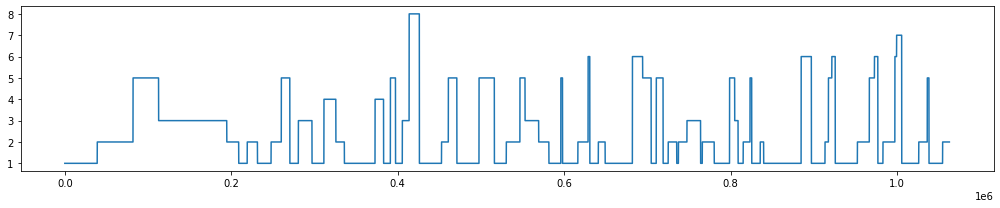

In [7]:
nn.plot_series(vs['mode'], figsize=figsize)

* The mode is _a controlled parameter_ and does not change in the middle of a segment
* Intuitively, the mode _has an impact_ on the machine behavior

## The Dataset

**Let's have a look at all the sensor readings**

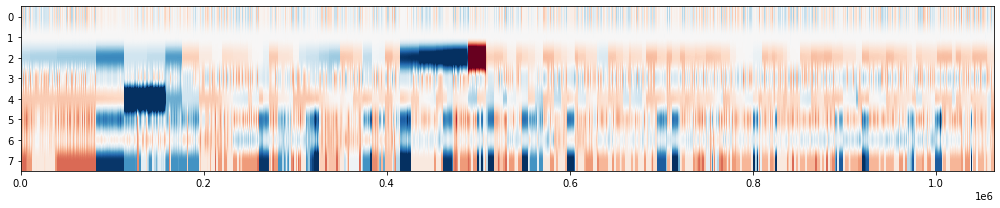

In [8]:
vss = vs.copy()
vss[vs_in] = (vss[vs_in] - vss[vs_in].mean()) / vss[vs_in].std()
nn.plot_dataframe(vss[vs_in], figsize=figsize)

# Data Preparation

## Binning

**This dataset contain _high-frequency data_ (4ms sampling period)**

* In this situation, feeding the raw data to a model does not usually make sense
* Instead, we reduce the frequency of the data via a process called _binning_

**A binning approach typically works as follows**

We apply a sliding window, but so that its consecutive applications _do not overlap_

* Each window application is called a _bin_
* ...From which we extract one or more _features_

**The result is series that contains a _smaller number of samples_**

...But typically a _larger number of features_

## Binning

**There are two broad classes of features that are usually extracted**

* _Time-domain_ features (e.g. mean, standard deviation)
* _Frequency-domain_ features (e.g. specific FFT amplitudes)

For this case, we will focus on time-domain features

**As a first step, we defined _which features_ we are going to extract**

In [9]:
functions = ['mean', 'std', 'skew', lambda x: x.kurtosis()]
aggmap = {a: functions for a in vs_in}
aggmap['mode'] = 'first'
str(aggmap)

"{'pCut::Motor_Torque': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pCut::CTRL_Position_controller::Lag_error': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pCut::CTRL_Position_controller::Actual_position': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pCut::CTRL_Position_controller::Actual_speed': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pSvolFilm::CTRL_Position_controller::Actual_position': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pSvolFilm::CTRL_Position_controller::Actual_speed': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pSvolFilm::CTRL_Position_controller::Lag_error': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'pSpintor::VAX_speed': ['mean', 'std', 'skew', <function <lambda> at 0x7f0f22d5be18>], 'mode': 'first'}"

## Binning

**Then we define bin numbers, and extract the features via a `groupby` operation**

We need to take care so that _no bin crosses between different segments_

In [10]:
%%time
binsize = 128
bins = []
for sname, sdata in vs.groupby('segment'):
    # Build the bin numbers
    sdata['bin'] = sdata.index // binsize
    # Apply the aggregation functions
    tmp = sdata.groupby('bin').agg(aggmap)
    bins.append(tmp)
vsb = pd.concat(bins)

CPU times: user 43.6 s, sys: 0 ns, total: 43.6 s
Wall time: 43.6 s


* This can be a relatively slow operation
* Bin numbers are usually easy to define using positional indexes and an integer division

## Binning

**If we choose the bin size correctly, we can speed up the operation**

* In particular, if all segments have the same length...
* ...And we choose bin size that is a submultiple of the segment length

...Then we can avoid processing each segment separately:

In [ ]:
%%time
# Build the bin numbers
binsize = 128
vsb = vs.copy()
vsb['bin'] = vs.index // binsize
vsb = vsb.groupby('bin').agg(aggmap)

* This kind of approach is significantly faster

## Binning

**The resulting dataframe has a hierarchical column index**

In [14]:
vsb.iloc[:1]

pCut::Motor_Torque                                 \
                  mean       std      skew <lambda_0>   
bin                                                     
0             0.475072  0.141935 -0.346041  -0.020202   

    pCut::CTRL_Position_controller::Lag_error                                \
                                         mean      std      skew <lambda_0>   
bin                                                                           
0                                    0.000205  0.04027  0.069676   0.350389   

    pCut::CTRL_Position_controller::Actual_position              ...  \
                                               mean         std  ...   
bin                                                              ...   
0                                      6.283919e+08  539.217959  ...   

    pSvolFilm::CTRL_Position_controller::Actual_speed  \
                                           <lambda_0>   
bin                                                     
0                                           -1.151468   

    pSvolFilm::CTRL_Position_controller::Lag_error                      \
                                              mean       std      skew   
bin                                                                      
0                                         0.966007  0.054749 -0.088401   

               pSpintor::VAX_speed                       mode  
    <lambda_0>                mean  std skew <lambda_0> first  
bin                                                            
0     -0.45759         1379.999756  0.0  0.0        0.0     1  

[1 rows x 33 columns]

**It may be worth _flattening_, so as to simplify access:**

In [16]:
if isinstance(vsb.columns, pd.MultiIndex):
    vsb.columns = ['::'.join(c) for c in vsb.columns]
vsb.iloc[:1]

,pCut::Motor_Torque::mean,pCut::Motor_Torque::std,pCut::Motor_Torque::skew,pCut::Motor_Torque::<lambda_0>,pCut::CTRL_Position_controller::Lag_error::mean,pCut::CTRL_Position_controller::Lag_error::std,pCut::CTRL_Position_controller::Lag_error::skew,pCut::CTRL_Position_controller::Lag_error::<lambda_0>,pCut::CTRL_Position_controller::Actual_position::mean,pCut::CTRL_Position_controller::Actual_position::std,...,pSvolFilm::CTRL_Position_controller::Actual_speed::<lambda_0>,pSvolFilm::CTRL_Position_controller::Lag_error::mean,pSvolFilm::CTRL_Position_controller::Lag_error::std,pSvolFilm::CTRL_Position_controller::Lag_error::skew,pSvolFilm::CTRL_Position_controller::Lag_error::<lambda_0>,pSpintor::VAX_speed::mean,pSpintor::VAX_speed::std,pSpintor::VAX_speed::skew,pSpintor::VAX_speed::<lambda_0>,mode::first
bin,,,,,,,,,,,,,,,,,,,,,
0,0.475072,0.141935,-0.346041,-0.020202,0.000205,0.04027,0.069676,0.350389,6.283919e+08,539.217959,...,-1.151468,0.966007,0.054749,-0.088401,-0.45759,1379.999756,0.0,0.0,0.0,1


## Standardization

**Before we can train any model, we need some preparation**

We will _standardize sensor inputs_ (all except the mode) using the first third of the series 

In [17]:
sep = int(np.round(len(vsb) * 0.34))
vsb_in = vsb.columns[:-1]
vsbs = vsb.copy()
tmp = vsbs[vsb_in].iloc[:sep]
vsbs[vsb_in] = (vsbs[vsb_in] - tmp.mean()) / tmp.std()
vsbs.iloc[:3]

,pCut::Motor_Torque::mean,pCut::Motor_Torque::std,pCut::Motor_Torque::skew,pCut::Motor_Torque::<lambda_0>,pCut::CTRL_Position_controller::Lag_error::mean,pCut::CTRL_Position_controller::Lag_error::std,pCut::CTRL_Position_controller::Lag_error::skew,pCut::CTRL_Position_controller::Lag_error::<lambda_0>,pCut::CTRL_Position_controller::Actual_position::mean,pCut::CTRL_Position_controller::Actual_position::std,...,pSvolFilm::CTRL_Position_controller::Actual_speed::<lambda_0>,pSvolFilm::CTRL_Position_controller::Lag_error::mean,pSvolFilm::CTRL_Position_controller::Lag_error::std,pSvolFilm::CTRL_Position_controller::Lag_error::skew,pSvolFilm::CTRL_Position_controller::Lag_error::<lambda_0>,pSpintor::VAX_speed::mean,pSpintor::VAX_speed::std,pSpintor::VAX_speed::skew,pSpintor::VAX_speed::<lambda_0>,mode::first
bin,,,,,,,,,,,,,,,,,,,,,
0,1.838916,-1.125481,0.478513,-0.549730,0.083036,-0.590987,0.461354,-0.672605,0.386059,-0.334643,...,-0.733193,0.116296,-0.820853,0.100392,-0.432482,-0.894283,-0.125539,0.219029,-0.025363,1
1,-0.336049,-0.424273,0.757608,-0.689435,-0.595970,-0.704050,0.654822,-0.650099,0.386054,-1.394564,...,-0.455596,-0.028925,-0.878265,0.093372,-0.303575,-0.894283,-0.125539,0.219029,-0.025363,1
2,-1.199835,0.860690,-1.275360,1.098302,0.238978,1.311934,-1.131721,0.891796,0.386061,1.092091,...,-0.720019,-0.523136,-0.344187,-1.489017,1.181348,-0.894283,-0.125539,0.219029,-0.025363,1


## Categorical Mode

**We will also adopt a _categorical encoding_ for the operating mode**

This is critical for neural network approaches in particular

In [19]:
from tensorflow.keras.utils import to_categorical
cmode = to_categorical(vsbs['mode::first'])
cols = [f'm{i}' for i in range(cmode.shape[1])]
cmode = pd.DataFrame(index=vsbs.index, data=cmode, columns=cols)
vsbs[cols] = cmode
vsbs.head()

,pCut::Motor_Torque::mean,pCut::Motor_Torque::std,pCut::Motor_Torque::skew,pCut::Motor_Torque::<lambda_0>,pCut::CTRL_Position_controller::Lag_error::mean,pCut::CTRL_Position_controller::Lag_error::std,pCut::CTRL_Position_controller::Lag_error::skew,pCut::CTRL_Position_controller::Lag_error::<lambda_0>,pCut::CTRL_Position_controller::Actual_position::mean,pCut::CTRL_Position_controller::Actual_position::std,...,mode::first,m0,m1,m2,m3,m4,m5,m6,m7,m8
bin,,,,,,,,,,,,,,,,,,,,,
0,1.838916,-1.125481,0.478513,-0.549730,0.083036,-0.590987,0.461354,-0.672605,0.386059,-0.334643,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.336049,-0.424273,0.757608,-0.689435,-0.595970,-0.704050,0.654822,-0.650099,0.386054,-1.394564,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.199835,0.860690,-1.275360,1.098302,0.238978,1.311934,-1.131721,0.891796,0.386061,1.092091,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.188107,-1.191551,0.250961,-0.443552,0.217620,-0.756159,0.505747,-0.649685,0.386070,-0.524966,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.252049,-0.947974,1.255687,-0.587060,-0.089580,-0.808065,0.080496,-0.615753,0.386073,-1.622526,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# KDE Approach

## KDE Approach

**Now, let's try anomaly detection via KDE**

First we estimate the optimal bandwidth:

In [20]:
%%time
vsbs_tr = vsbs.iloc[:sep]

params = {'bandwidth': np.linspace(0.2, 0.8, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
opt.fit(vsbs_tr)
best_params = pd.Series(index=opt.best_params_.keys(), data=opt.best_params_.values())
print(best_params)    

bandwidth    0.333333
dtype: float64
CPU times: user 8.04 s, sys: 8.95 ms, total: 8.05 s
Wall time: 8.07 s


## KDE Approach

**Then we can train an estimator**

In [21]:
h = opt.best_params_['bandwidth']
kde = KernelDensity(bandwidth=h)
kde.fit(vsbs_tr)

KernelDensity(bandwidth=0.33333333333333337)

**...And we can generate the alarm signal**

In [22]:
%%time
ldens = kde.score_samples(vsbs)
signal_kde = pd.Series(index=vsbs.index, data=-ldens)

CPU times: user 3.02 s, sys: 4.31 ms, total: 3.03 s
Wall time: 3.02 s


## KDE Approach

**Let's plot the signal**

In [24]:
nn.plot_signal(signal_kde, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* A peak at mid run makes the signal difficult to read

## KDE Approach

**Since the anomaly arises slowly, it makes sense to _clip_ and _smooth_ the signal**

In [29]:
nn.plot_signal(signal_kde.clip(upper=25).ewm(512).mean(), figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* The smoothed signal has a tendency to grow
* There is a plateau in the middle that is difficult to explain

# Autoencoder Approach

## Autoencoder Approach

**Let's repeat our analysis using an autoencoder**

First we define its structure:

In [33]:
input_shape = vsbs.shape[1]
output_shape = len(vsb_in)
ae_x = keras.Input(shape=input_shape, dtype='float32')
ae_z = Dense(16, activation='relu')(ae_x)
ae_y = Dense(output_shape, activation='linear')(ae_z)
ae = keras.Model(ae_x, ae_y)

* The input includes the operating mode
* ...But _the output does not_!

We have _no interest in reconstructing controlled parameters_

## Autoencoder Approach

**Now we can perform training**

In [34]:
%%time
ae.compile(optimizer='RMSProp', loss='mse')
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
history = ae.fit(vsbs_tr, vsbs_tr[vsb_in], validation_split=0.2, callbacks=callbacks,
                 batch_size=32, epochs=50, verbose=2)

Epoch 1/50
71/71 - 0s - loss: 0.9992 - val_loss: 0.6601
Epoch 2/50
71/71 - 0s - loss: 0.6836 - val_loss: 0.4621
Epoch 3/50
71/71 - 0s - loss: 0.4980 - val_loss: 0.3478
Epoch 4/50
71/71 - 0s - loss: 0.4001 - val_loss: 0.2919
Epoch 5/50
71/71 - 0s - loss: 0.3441 - val_loss: 0.2556
Epoch 6/50
71/71 - 0s - loss: 0.3057 - val_loss: 0.2313
Epoch 7/50
71/71 - 0s - loss: 0.2766 - val_loss: 0.2095
Epoch 8/50
71/71 - 0s - loss: 0.2532 - val_loss: 0.1921
Epoch 9/50
71/71 - 0s - loss: 0.2331 - val_loss: 0.1740
Epoch 10/50
71/71 - 0s - loss: 0.2159 - val_loss: 0.1620
Epoch 11/50
71/71 - 0s - loss: 0.2011 - val_loss: 0.1505
Epoch 12/50
71/71 - 0s - loss: 0.1882 - val_loss: 0.1386
Epoch 13/50
71/71 - 0s - loss: 0.1767 - val_loss: 0.1309
Epoch 14/50
71/71 - 0s - loss: 0.1676 - val_loss: 0.1240
Epoch 15/50
71/71 - 0s - loss: 0.1600 - val_loss: 0.1174
Epoch 16/50
71/71 - 0s - loss: 0.1531 - val_loss: 0.1119
Epoch 17/50
71/71 - 0s - loss: 0.1474 - val_loss: 0.1079
Epoch 18/50
71/71 - 0s - loss: 0.1416 - 

## Autoencoder Approach

**Let's see the loss evolution over time**

In [35]:
nn.plot_training_history(history, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Autoencoder Approach

**Then we obtain our predictions**

In [36]:
%%time
preds = ae.predict(vsbs)
preds = pd.DataFrame(index=vsbs.index, columns=vsb_in, data=preds)

CPU times: user 263 ms, sys: 149 ms, total: 413 ms
Wall time: 291 ms


...And we generate the alarm signal:

In [38]:
se = np.square(preds - vsbs[vsb_in])
sse = np.sum(se, axis=1)
signal_ae = pd.Series(index=vsbs.index, data=sse)

* We stored also the individual errors `se` for a later analysis

## Autoencoder Approach

**We can now plot the alarm signal**

In [39]:
nn.plot_signal(signal_ae, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* Once again, the signal is difficult to read due to the peak

## Autoencoder Approach

**Let's apply clipping and smoothing**

In [56]:
nn.plot_signal(signal_ae.clip(upper=10).ewm(512).mean(), figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* Again, a tendency to grow (weaker than before)
* ...But this time _we can try  to explain the peak_!

## Mutiple Signal Analysis

**Let's investigate the situation**

In [42]:
signals_ae = pd.DataFrame(index=vsbs.index, columns=vsb_in, data=se)
nn.plot_dataframe(signals_ae, vmin=-1, vmax=1, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* As expected, errors are concentrated on a few features

## Multiple Signal Analysis

**Let's focus on the peak at mid run and check the largest errors**

In [43]:
tmp = se.iloc[3500:4000].mean().sort_values(ascending=False)[:10]
nn.plot_bars(tmp, figsize=figsize, tick_gap=-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
print(f'The largest error is on {tmp.index[0]}')

The largest error is on pSvolFilm::CTRL_Position_controller::Actual_position::<lambda_0>


## Multiple Signal Analysis

**Let's what was going on with the original series**

In [47]:
nn.plot_series(vs['pCut::CTRL_Position_controller::Actual_position'], figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* Indeed, _there is an unusual oscillation_! A domain expert may make sense of that

# RNVP Approach

## RNVP Approach

**Let's make an attempt with Real NVP**

In [48]:
%%time
vs_rnvp = nn.RealNVP(input_shape=vsbs.shape[1],
                num_coupling=6, units_coupling=32, depth_coupling=1, reg_coupling=0.01)
vs_rnvp.compile(optimizer='Adam')
X = vsbs_tr.astype(np.float32).values
cb = [EarlyStopping(monitor='loss', patience=10, min_delta=0.001, restore_best_weights=True)]
history = vs_rnvp.fit(X, batch_size=256, epochs=300, verbose=1, callbacks=cb)

Epoch 1/300
12/12 [==============================] - 0s 6ms/step - loss: 219.0808
Epoch 2/300
12/12 [==============================] - 0s 5ms/step - loss: 102.5352
Epoch 3/300
12/12 [==============================] - 0s 6ms/step - loss: 77.7634
Epoch 4/300
12/12 [==============================] - 0s 6ms/step - loss: 68.9585
Epoch 5/300
12/12 [==============================] - 0s 6ms/step - loss: 66.0839
Epoch 6/300
12/12 [==============================] - 0s 6ms/step - loss: 63.3582
Epoch 7/300
12/12 [==============================] - 0s 6ms/step - loss: 61.7042
Epoch 8/300
12/12 [==============================] - 0s 6ms/step - loss: 59.6041
Epoch 9/300
12/12 [==============================] - 0s 6ms/step - loss: 58.0961
Epoch 10/300
12/12 [==============================] - 0s 6ms/step - loss: 56.0438
Epoch 11/300
12/12 [==============================] - 0s 6ms/step - loss: 54.8829
Epoch 12/300
12/12 [==============================] - 0s 6ms/step - loss: 53.0074
Epoch 13/300
12/12 [===

12/12 [==============================] - 0s 5ms/step - loss: -25.7198
Epoch 199/300
12/12 [==============================] - 0s 6ms/step - loss: -25.6144
Epoch 200/300
12/12 [==============================] - 0s 6ms/step - loss: -26.6355
Epoch 201/300
12/12 [==============================] - 0s 5ms/step - loss: -27.3193
Epoch 202/300
12/12 [==============================] - 0s 6ms/step - loss: -26.1383
Epoch 203/300
12/12 [==============================] - 0s 5ms/step - loss: -26.8192
Epoch 204/300
12/12 [==============================] - 0s 5ms/step - loss: -27.0570
Epoch 205/300
12/12 [==============================] - 0s 6ms/step - loss: -27.6914
Epoch 206/300
12/12 [==============================] - 0s 6ms/step - loss: -27.8962
Epoch 207/300
12/12 [==============================] - 0s 6ms/step - loss: -27.4468
Epoch 208/300
12/12 [==============================] - 0s 5ms/step - loss: -27.9031
Epoch 209/300
12/12 [==============================] - 0s 5ms/step - loss: -28.0876
Epoch 

## RNVP Approach

**Let's have a look at the loss evolution over time**

In [49]:
nn.plot_training_history(history, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## RNVP Approach

**Now we can generate and plot the signal**

In [50]:
ldens = vs_rnvp.score_samples(vsbs.astype(np.float32).values)
signal_vs = pd.Series(index=vsbs.index, data=-ldens)
nn.plot_signal(signal_vs, figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## RNVP Approach

**Finally, we apply clipping and smoothing**

In [52]:
nn.plot_signal(signal_vs.clip(upper=10).ewm(512).mean(), figsize=figsize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* This is the signal with _the clearest trend so far_
* Intuitively, component wear should grow _progressively_ over time